In [15]:

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gspread
from google.colab import drive, auth
from google.auth import default

from scipy.interpolate import interp1d
from statsmodels.stats.proportion import (
    proportions_ztest,
    proportion_confint
)

from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.interpolate import interp1d
from scipy.stats import linregress
from scipy.stats import norm
import itertools

## Dose-responses

In [17]:


def load_dose_response(sheet_url, tab_name):
    """
    Load a tab-separated worksheet from a public Google Sheet.

    Parameters:
        sheet_url (str): URL of the Google Sheet.
        tab_name (str): Name of the tab (worksheet) to load.

    Returns:
        pd.DataFrame: Loaded data as a pandas DataFrame.
    """
    # Extract the Sheet ID
    sheet_id = sheet_url.split('/d/')[1].split('/')[0]

    # Construct CSV export URL
    csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={tab_name}"

    # Load it into a DataFrame
    df = pd.read_csv(csv_url)
    return df

def filter_dose_response(df, strain=None, stress=None, time=None):
    """
    Filter growth data by strain, stress, and time, and return dose, mean, and sd values.

    Parameters:
        df (pd.DataFrame): The input DataFrame with growth data.
        strain (str or None): Strain name to filter. If None, do not filter by strain.
        stress (str or None): Stress type to filter. If None, do not filter by stress.
        time (float or None): Time point to filter. If None, do not filter by time.

    Returns:
        pd.DataFrame: Filtered DataFrame with columns ['dose', 'mean', 'sd'].
    """
    df_filtered = df.copy()

    if strain is not None:
        df_filtered = df_filtered[df_filtered['strain'] == strain]
    if stress is not None:
        df_filtered = df_filtered[df_filtered['stress'] == stress]
    if time is not None:
        df_filtered = df_filtered[df_filtered['time'] == time]

    return df_filtered[['dose', 'mean', 'sd']].reset_index(drop=True)

tab_name = "dose_responses"
df_dose_response = load_dose_response(sheet_url, tab_name)
df_dose_response.head()

,time,stress,dose,strain,mean,sd
0,0.0,AMP,0.00,MC1061,0.015000,0.001155
1,0.0,AMP,0.00,MC-SCFP3A,0.014000,0.001155
2,0.0,AMP,0.00,VIP,0.014667,0.001202
3,0.0,AMP,0.00,VIP205,0.015333,0.000333
4,0.0,AMP,0.25,MC1061,0.013667,0.001453


In [18]:


def compute_ic50_with_error(data, target_inhibition=50):
    # Sort data
    data = data.sort_values('dose')
    od_0 = data['mean'].iloc[0]
    od_max = data['mean'].iloc[-1]
    denom = od_0 - od_max
    if denom == 0:
        return None, None

    # Calculate inhibition and propagated error
    inhibition = 1 - (data['mean'] - od_max) / denom
    inhibition = inhibition.clip(0, 1) * 100
    error = data['sd'] / denom * 100

    # Find pair of points surrounding the target inhibition
    for i in range(len(inhibition) - 1):
        if inhibition.iloc[i] <= target_inhibition <= inhibition.iloc[i + 1] or \
           inhibition.iloc[i] >= target_inhibition >= inhibition.iloc[i + 1]:
            x1, x2 = inhibition.iloc[i], inhibition.iloc[i + 1]
            y1, y2 = data['dose'].iloc[i], data['dose'].iloc[i + 1]
            e1, e2 = error.iloc[i], error.iloc[i + 1]
            break
    else:
        return None, None  # Could not interpolate

    # Linear interpolation formula
    m = (y2 - y1) / (x2 - x1)
    ic50 = y1 + (target_inhibition - x1) * m

    # Error propagation: σ_IC50 = sqrt[(∂IC50/∂x1)^2 * σ1^2 + (∂IC50/∂x2)^2 * σ2^2]
    dx = x2 - x1
    d_ic50_dx1 = -(y2 - y1) / dx + (target_inhibition - x1) * (y2 - y1) / dx**2
    d_ic50_dx2 = (target_inhibition - x1) / dx
    sigma_ic50 = np.sqrt((d_ic50_dx1 * e1)**2 + (d_ic50_dx2 * e2)**2)

    return ic50, sigma_ic50

IC50 for MC1061: 0.22 pm 1.47
IC50 for VIP205: 0.40 pm 1.49
IC50 for MC-SCFP3A: 0.31 pm 0.04


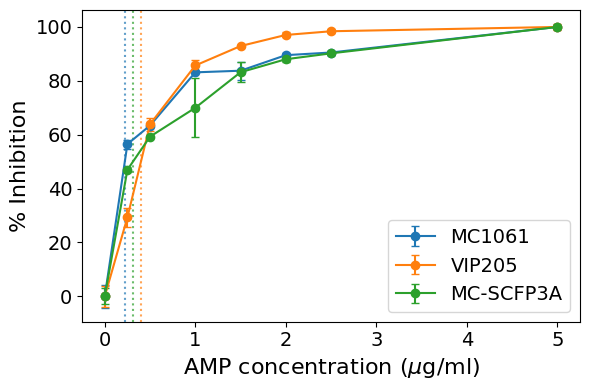

IC50 for MC1061: 0.12 pm 0.20
IC50 for VIP205: 0.07 pm 0.60
IC50 for MC-SCFP3A: 0.05 pm 2.50


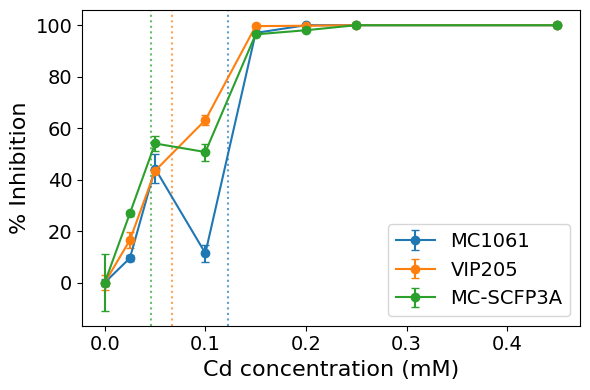

In [19]:
def plot_dose_response(df, strains, stress, time, ylabel="% Inhibition", title=None):
    """
    Plot dose vs. % inhibition for multiple strains with error bars.
    Add a vertical dotted line at IC99 (99% inhibition) for each strain.
    Return a dictionary with interpolated IC99 values.
    """
    plt.figure(figsize=(6, 4))
    ic50_values = {}
    colors = plt.cm.tab10.colors  # Get default color cycle

    for i, strain in enumerate(strains):
        data = df[(df['strain'] == strain) & (df['stress'] == stress) & (df['time'] == time)]
        if data.empty or len(data) < 2:
            continue

        # Sort data by dose
        data = data.sort_values('dose')

        # Get OD values at min and max dose
        od_0 = data['mean'].iloc[0]
        od_max = data['mean'].iloc[-1]

        denom = od_0 - od_max
        if denom == 0:
            continue

        # Calculate inhibition and error
        inhibition = 1 - (data['mean'] - od_max) / denom
        inhibition = inhibition.clip(0, 1) * 100
        error = data['sd'] / denom * 100

        # Plot dose-response curve
        plt.errorbar(
            data['dose'], inhibition, yerr=error,
            label=strain, marker='o', capsize=3, color=colors[i % len(colors)]
        )

        # Interpolate and estimate IC99
        ic50, ic50_err = compute_ic50_with_error(data)
        ic50_values[strain] = (ic50, ic50_err)
        print(f"IC50 for {strain}: {ic50:.2f} pm {ic50_err:.2f}")
        plt.axvline(ic50, linestyle='dotted', color=colors[i % len(colors)], alpha=0.7)

    if stress=='Cd':
      lbl=f"{stress} concentration (mM)"
    else:
      lbl=f"{stress} concentration ($\mu$g/ml)"
    plt.xlabel(lbl, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return ic50_values

ic50_values_AMP =plot_dose_response(df_dose_response, strains=['MC1061', 'VIP205', 'MC-SCFP3A'], stress='AMP', time=20.0)
ic50_values_Cd =plot_dose_response(df_dose_response, strains=['MC1061', 'VIP205',  'MC-SCFP3A'], stress='Cd', time=20.0)


In [20]:

def compare_ic50s(ic50_dict):
    """
    Perform pairwise Z-tests between strains based on IC50 values and their uncertainties.

    Parameters:
        ic50_dict (dict): Dictionary with strain names as keys and (IC50, std_dev) tuples as values.

    Returns:
        list of tuples: Each tuple contains (strain1, strain2, z_score, p_value)
    """
    results = []
    strains = list(ic50_dict.keys())

    for s1, s2 in itertools.combinations(strains, 2):
        ic1, sd1 = ic50_dict[s1]
        ic2, sd2 = ic50_dict[s2]

        # Skip comparison if any error is None
        if None in (ic1, sd1, ic2, sd2):
            continue

        # Z-test
        z = (ic1 - ic2) / np.sqrt(sd1**2 + sd2**2)
        p = 2 * (1 - norm.cdf(abs(z)))  # two-tailed p-value
        results.append((s1, s2, z, p))

    return results

print("**** AMP:")
results = compare_ic50s(ic50_values_AMP)
for s1, s2, z, p in results:
    print(f"{s1} vs. {s2}: Z = {z:.3f}, p = {p:.4f}")


print("\n**** Cd:")
results = compare_ic50s(ic50_values_Cd)
for s1, s2, z, p in results:
    print(f"{s1} vs. {s2}: Z = {z:.3f}, p = {p:.4f}")

**** AMP:
MC1061 vs. VIP205: Z = -0.085, p = 0.9321
MC1061 vs. MC-SCFP3A: Z = -0.061, p = 0.9513
VIP205 vs. MC-SCFP3A: Z = 0.059, p = 0.9526

**** Cd:
MC1061 vs. VIP205: Z = 0.088, p = 0.9301
MC1061 vs. MC-SCFP3A: Z = 0.030, p = 0.9757
VIP205 vs. MC-SCFP3A: Z = 0.008, p = 0.9937


## Growth curves

In [21]:

def load_growth_data(sheet_url, tab_name):
    """
    Load a tab-separated worksheet from a public Google Sheet.

    Parameters:
        sheet_url (str): URL of the Google Sheet.
        tab_name (str): Name of the tab (worksheet) to load.

    Returns:
        pd.DataFrame: Loaded data as a pandas DataFrame.
    """
    # Extract the Sheet ID
    sheet_id = sheet_url.split('/d/')[1].split('/')[0]

    # Construct CSV export URL
    csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={tab_name}"

    # Load it into a DataFrame
    df = pd.read_csv(csv_url)
    return df

def filter_growth_data(df, dose=None, strain=None, stress=None, time=None):
    """
    Filter growth data by dose, stress, and time, and return dose, mean, and sd values.

    Parameters:
        df (pd.DataFrame): The input DataFrame with growth data.
        dose (str or None): Dose name to filter. If None, do not filter by dose.
        stress (str or None): Stress type to filter. If None, do not filter by stress.
        time (float or None): Time point to filter. If None, do not filter by time.

    Returns:
        pd.DataFrame: Filtered DataFrame with columns ['dose', 'mean', 'sd'].
    """
    df_filtered = df.copy()

    if dose is not None:
        df_filtered = df_filtered[df_filtered['dose'] == dose]
    if strain is not None:
        df_filtered = df_filtered[df_filtered['strain'] == strain]
    if stress is not None:
        df_filtered = df_filtered[df_filtered['stress'] == stress]
    if time is not None:
        df_filtered = df_filtered[df_filtered['time'] == time]

    return df_filtered[['time', 'OD_value']].reset_index(drop=True)


tab_name = "growth_curves"
df_growth_data = load_growth_data(sheet_url, tab_name)
df_growth_data.head()


,time,replicate,stress,dose,units,strain,OD_value,Unnamed: 7,Unnamed: 8
0,0.000000,rep1,AMP,0,ug/mL,MC1061,0.087,NaN,NaN
1,0.000000,rep2,AMP,0,ug/mL,MC1061,0.085,NaN,NaN
2,0.000000,rep3,AMP,0,ug/mL,MC1061,0.083,NaN,NaN
3,0.333333,rep1,AMP,0,ug/mL,MC1061,0.085,NaN,NaN
4,0.333333,rep2,AMP,0,ug/mL,MC1061,0.083,NaN,NaN


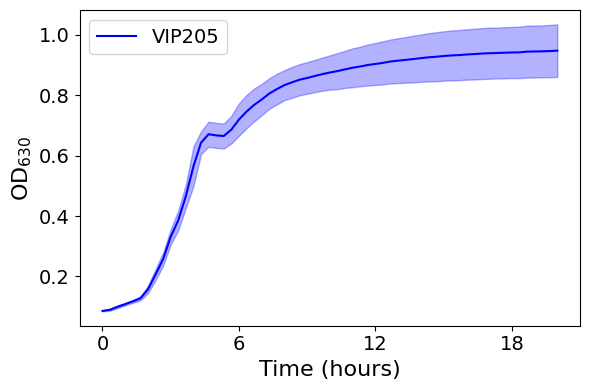

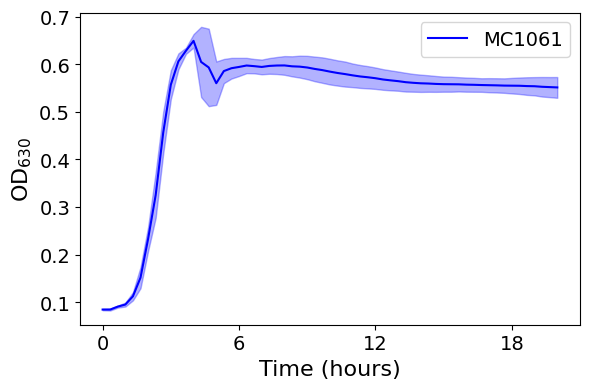

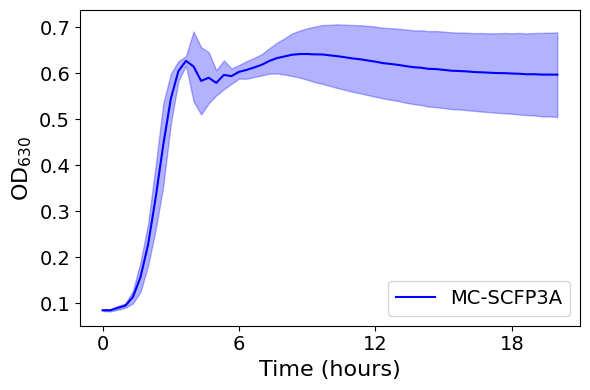

In [22]:


def plot_growth_curve(df_filtered, label=None, color=None):
    """
    Plot the mean OD over time with standard deviation as a shaded area.

    Parameters:
        df_filtered (pd.DataFrame): Must contain 'time' and 'OD_value' columns.
        label (str or None): Label for the curve (e.g., strain or condition).
        color (str or None): Matplotlib color code (optional).
    """
    # Group by time and compute mean and std
    grouped = df_filtered.groupby('time')['OD_value'].agg(['mean', 'std']).reset_index()

    plt.figure(figsize=(6, 4))
    # Plot with error shading
    plt.plot(grouped['time'], grouped['mean'], label=label, color=color)
    plt.fill_between(
        grouped['time'],
        grouped['mean'] - grouped['std'],
        grouped['mean'] + grouped['std'],
        alpha=0.3,
        color=color
    )

    plt.xlabel('Time (hours)', fontsize=16)
    plt.ylabel('OD$_{630}$', fontsize=16)
    plt.xticks([0, 6, 12, 18],fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(False)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

ODdata_VIP = filter_growth_data(df_growth_data, dose=0.0, strain='VIP205')
plot_growth_curve(ODdata_VIP, label='VIP205', color='blue')

ODdata_MC = filter_growth_data(df_growth_data, dose=0.0, strain='MC1061')
plot_growth_curve(ODdata_MC, label='MC1061', color='blue')


ODdata_MC = filter_growth_data(df_growth_data, dose=0.0, strain='MC-SCFP3A')
plot_growth_curve(ODdata_MC, label='MC-SCFP3A', color='blue')

In [23]:
def compute_mu_max(df_filtered):
    """
    Compute the maximum growth rate (mu_max) from mean OD over time.
    """
    grouped = df_filtered.groupby('time')['OD_value'].mean().reset_index()
    grouped = grouped[grouped['OD_value'] > 0]
    grouped['log_OD'] = np.log(grouped['OD_value'])
    dt = np.diff(grouped['time'])
    dlogOD = np.diff(grouped['log_OD'])
    mu_values = dlogOD / dt
    return np.max(mu_values)

def compute_mu_max_per_replicate(df):
    """
    Compute mu_max per replicate from raw OD data.
    Assumes df contains 'time', 'OD_value', and 'replicate' columns.
    """
    mu_per_rep = {}
    for rep_id, group in df.groupby('replicate'):
        mu = compute_mu_max(group)
        mu_per_rep[rep_id] = mu
    return list(mu_per_rep.values())

def print_summary_and_compare(label1, mu1, label2, mu2):
    mean1, std1 = np.mean(mu1), np.std(mu1, ddof=1)
    mean2, std2 = np.mean(mu2), np.std(mu2, ddof=1)
    print(f"{label1}: μ_max = {mean1:.4f} ± {std1:.4f} h⁻¹")
    print(f"{label2}: μ_max = {mean2:.4f} ± {std2:.4f} h⁻¹")
    stat, pval = ttest_ind(mu1, mu2, equal_var=False)
    print(f"p-value ({label1} vs {label2}): {pval:.4f}\n")

# Load and filter data
vip_data = df_growth_data[(df_growth_data['strain'] == 'VIP') & (df_growth_data['stress'] == 'AMP')]
mc_data  = df_growth_data[(df_growth_data['strain'] == 'MC1061') & (df_growth_data['stress'] == 'AMP')]
cfp_data = df_growth_data[(df_growth_data['strain'] == 'MC-SCFP3A') & (df_growth_data['stress'] == 'AMP')]

vip_mu = compute_mu_max_per_replicate(vip_data)
mc_mu  = compute_mu_max_per_replicate(mc_data)
cfp_mu = compute_mu_max_per_replicate(cfp_data)

# Print comparisons
print_summary_and_compare("VIP205", vip_mu, "MC1061", mc_mu)
print_summary_and_compare("MC-SCFP3A", cfp_mu, "MC1061", mc_mu)


VIP205: μ_max = 0.8643 ± 0.1215 h⁻¹
MC1061: μ_max = 1.3553 ± 0.0216 h⁻¹
p-value (VIP205 vs MC1061): 0.0173

MC-SCFP3A: μ_max = 1.3394 ± 0.1014 h⁻¹
MC1061: μ_max = 1.3553 ± 0.0216 h⁻¹
p-value (MC-SCFP3A vs MC1061): 0.8136



## Single-cell analysis

In [24]:


def load_stats(data_path, expeID):
    """
    Loads the statistics stored in a pickle file.

    Parameters:
    - data_path: Base directory where the file is stored.
    - expeID: Experiment ID used to name the file.

    Returns:
    - A dictionary containing the stored statistics.
      Expected keys are 'stats_VIP' and 'stats_CFP'.
    """
    filename = os.path.join(data_path, expeID + '.pkl')
    with open(filename, 'rb') as f:
        stats = pickle.load(f)
    print(f"Loaded statistics from {filename}")
    return stats['stats_VIP'],stats['stats_CFP']


expeID_Amp = 'vip_Amp'
stats_VIP_Amp, stats_CFP_Amp = load_stats(data_path, expeID_Amp)
print("VIP Stats (Amp):", stats_VIP_Amp)
print("CFP Stats (Amp):", stats_CFP_Amp)


expeID_Cd = 'vip_Cd'
stats_VIP_Cd, stats_CFP_Cd = load_stats(data_path, expeID_Cd)
print("VIP Stats (Cd):", stats_VIP_Cd)
print("CFP Stats (Cd):", stats_CFP_Cd)

Loaded statistics from /content/drive/MyDrive/SYNC_Projects/VIP205/MotherMachine/data/vip_Amp.pkl
VIP Stats (Amp): {'filter_type': 'VIP', 'num_cells': 105, 'num_survived': 35, 'num_non_survived': 70, 'survival_percentage': 33.33333333333333, 'mean_cell_length': (np.float64(6.3680009363295875), np.float64(2.5747937232383467), 'μm'), 'mean_divisions': (np.float64(0.2045880149812734), np.float64(0.4034002467863594), 'count'), 'mean_division_rate': (np.float64(0.02126414027149321), np.float64(0.005183754100445217), 'divisions/min'), 'mean_elongation_rate': (np.float64(0.01801458023554958), np.float64(0.6165213532206276), 'μm/min'), 'mean_time_between_divisions': (np.float64(77.25488219526122), np.float64(29.11777597940027), 'minutes')}
CFP Stats (Amp): {'filter_type': 'CFP', 'num_cells': 78, 'num_survived': 23, 'num_non_survived': 55, 'survival_percentage': 29.48717948717949, 'mean_cell_length': (np.float64(6.602713333333333), np.float64(5.886907102870082), 'μm'), 'mean_divisions': (np.flo

Survival AMP:
VIP205: 33.33333333333333 percent
Control: 29.48717948717949 percent
(p = 0.6948)
Survival Cd:
VIP205 62.5 percent:
Control 60.15625 percent:
(p = 0.7455)


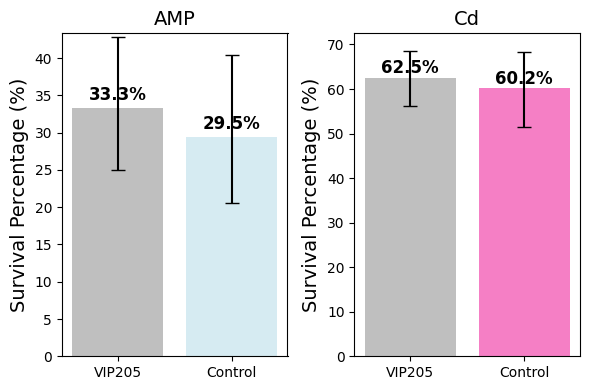

In [25]:


# Define a function to compute the Wilson confidence interval
def wilson_ci(k, n, confidence=0.95):
    if n == 0:
        return 0, 0
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    p_hat = k / n
    denominator = 1 + (z ** 2 / n)
    center = (p_hat + (z ** 2 / (2 * n))) / denominator
    margin = (z * np.sqrt((p_hat * (1 - p_hat) / n) + (z ** 2 / (4 * n ** 2)))) / denominator
    return center - margin, center + margin

# --- Data for Amp condition (replace these with your actual values) ---
# For Amp condition
n_vip_amp = stats_VIP_Amp['num_cells']
k_vip_amp = stats_VIP_Amp['num_survived']
p_vip_amp = k_vip_amp / n_vip_amp

n_cfp_amp = stats_CFP_Amp['num_cells']
k_cfp_amp = stats_CFP_Amp['num_survived']
p_cfp_amp = k_cfp_amp / n_cfp_amp

ci_vip_amp = wilson_ci(k_vip_amp, n_vip_amp)
ci_cfp_amp = wilson_ci(k_cfp_amp, n_cfp_amp)

# Perform chi-square test for Amp condition
contingency_amp = np.array([[k_vip_amp, n_vip_amp - k_vip_amp],
                            [k_cfp_amp, n_cfp_amp - k_cfp_amp]])
chi2_amp, p_value_amp, _, _ = stats.chi2_contingency(contingency_amp)

# --- Data for Cd condition (replace these with your actual values) ---
n_vip_cd = stats_VIP_Cd['num_cells']
k_vip_cd = stats_VIP_Cd['num_survived']
p_vip_cd = k_vip_cd / n_vip_cd

n_cfp_cd = stats_CFP_Cd['num_cells']
k_cfp_cd = stats_CFP_Cd['num_survived']
p_cfp_cd = k_cfp_cd / n_cfp_cd

ci_vip_cd = wilson_ci(k_vip_cd, n_vip_cd)
ci_cfp_cd = wilson_ci(k_cfp_cd, n_cfp_cd)

# Perform chi-square test for Cd condition
contingency_cd = np.array([[k_vip_cd, n_vip_cd - k_vip_cd],
                           [k_cfp_cd, n_cfp_cd - k_cfp_cd]])
chi2_cd, p_value_cd, _, _ = stats.chi2_contingency(contingency_cd)

# --- Prepare the bar chart for each condition ---
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

# Define labels and colors
labels = ['VIP205', 'Control']

# Amp condition
percentages_amp = [p_vip_amp * 100, p_cfp_amp * 100]
ci_lower_amp = [percentages_amp[0] - (ci_vip_amp[0] * 100), percentages_amp[1] - (ci_cfp_amp[0] * 100)]
ci_upper_amp = [(ci_vip_amp[1] * 100) - percentages_amp[0], (ci_cfp_amp[1] * 100) - percentages_amp[1]]

axes[0].bar(labels, percentages_amp, yerr=[ci_lower_amp, ci_upper_amp], capsize=5,
            color=['grey', '#AED8E6'], alpha=0.5)
axes[0].set_ylabel("Survival Percentage (%)", fontsize=14)
axes[0].set_title(f"AMP", fontsize=14)
print("Survival AMP:")
print("VIP205: %s percent"%percentages_amp[0])
print("Control: %s percent"%percentages_amp[1])
print(f"(p = {p_value_amp:.4f})")
axes[0].set_ylim(0, max(percentages_amp) + 10)
for i, v in enumerate(percentages_amp):
    axes[0].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12, fontweight='bold')

# Cd condition
percentages_cd = [p_vip_cd * 100, p_cfp_cd * 100]
ci_lower_cd = [percentages_cd[0] - (ci_vip_cd[0] * 100), percentages_cd[1] - (ci_cfp_cd[0] * 100)]
ci_upper_cd = [(ci_vip_cd[1] * 100) - percentages_cd[0], (ci_cfp_cd[1] * 100) - percentages_cd[1]]

axes[1].bar(labels, percentages_cd, yerr=[ci_lower_cd, ci_upper_cd], capsize=5,
            color=['grey', '#EC008C'], alpha=0.5)
axes[1].set_ylabel("Survival Percentage (%)", fontsize=14)
axes[1].set_title(f"Cd", fontsize=14)

print("Survival Cd:")
print("VIP205 %s percent:"%percentages_cd[0])
print("Control %s percent:"%percentages_cd[1])
print(f"(p = {p_value_cd:.4f})")
axes[1].set_ylim(0, max(percentages_cd) + 10)
for i, v in enumerate(percentages_cd):
    axes[1].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [26]:
from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np

def compute_stat_comparison(dict1, dict2, keys_to_skip=None):
    """
    Compare numeric statistics between two dictionaries.

    For each key (except those in keys_to_skip), this function extracts the mean and standard deviation
    (assumed to be stored as a tuple: (mean, std, unit)) from dict1 and dict2, generates a small dataset
    using mean ± std, and then computes p-values using both an independent t-test and a Mann-Whitney U test.

    Parameters:
      dict1: dict, statistics for group 1 (e.g., VIP)
      dict2: dict, statistics for group 2 (e.g., CFP)
      keys_to_skip: list of keys to exclude from comparison (default: None)

    Returns:
      comparison_results: dict mapping each metric key to a dictionary with:
          - "unit": unit of the measurement
          - "Group1_mean": mean value for group 1
          - "Group2_mean": mean value for group 2
          - "t-test_p-value": p-value from the t-test
          - "Mann-Whitney_p-value": p-value from the Mann-Whitney U test
    """
    if keys_to_skip is None:
        keys_to_skip = []

    comparison_results = {}
    for key in dict1:
        if key in keys_to_skip:
            continue
        # Ensure both dictionaries have a tuple for this key
        if isinstance(dict1[key], tuple) and isinstance(dict2[key], tuple):
            mean1, std1, unit1 = dict1[key]
            mean2, std2, unit2 = dict2[key]
            # Create simple datasets: [mean - std, mean, mean + std]
            group1 = [mean1 - std1, mean1, mean1 + std1]
            group2 = [mean2 - std2, mean2, mean2 + std2]

            # Only perform tests if there is non-zero variance
            if np.var(group1) > 0 and np.var(group2) > 0:
                t_stat, t_p_value = ttest_ind(group1, group2, equal_var=False)
                u_stat, u_p_value = mannwhitneyu(group1, group2, alternative="two-sided")
            else:
                t_p_value = np.nan
                u_p_value = np.nan

            comparison_results[key] = {
                "unit": unit1,
                "Group1_mean": mean1,
                "Group2_mean": mean2,
                "Group1_std": std1,
                "Group2_std": std2,
                "t-test_p-value": t_p_value,
                "Mann-Whitney_p-value": u_p_value
            }
    return comparison_results

# Example usage:
keys_to_skip = ["filter_type", "critical_timepoint_frames", "critical_timepoint_minutes"]
comparison_results_Amp = compute_stat_comparison(stats_VIP_Amp, stats_CFP_Amp, keys_to_skip)
print("\nComparison Results (VIP205 vs CFP):")
for metric, res in comparison_results_Amp.items():
    print(f"\nAMP: Metric: {metric}")
    for key, value in res.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")

comparison_results_Cd = compute_stat_comparison(stats_VIP_Cd, stats_CFP_Cd, keys_to_skip)
print("\nComparison Results (VIP205 vs CFP):")
for metric, res in comparison_results_Cd.items():
    print(f"\nCd: Metric: {metric}")
    for key, value in res.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")


Comparison Results (VIP205 vs CFP):

AMP: Metric: mean_cell_length
  unit: μm
  Group1_mean: 6.3680
  Group2_mean: 6.6027
  Group1_std: 2.5748
  Group2_std: 5.8869
  t-test_p-value: 0.9539
  Mann-Whitney_p-value: 1.0000

AMP: Metric: mean_divisions
  unit: count
  Group1_mean: 0.2046
  Group2_mean: 0.1827
  Group1_std: 0.4034
  Group2_std: 0.3864
  t-test_p-value: 0.9491
  Mann-Whitney_p-value: 0.7000

AMP: Metric: mean_division_rate
  unit: divisions/min
  Group1_mean: 0.0213
  Group2_mean: 0.0190
  Group1_std: 0.0052
  Group2_std: 0.0056
  t-test_p-value: 0.6309
  Mann-Whitney_p-value: 0.7000

AMP: Metric: mean_elongation_rate
  unit: μm/min
  Group1_mean: 0.0180
  Group2_mean: 0.0113
  Group1_std: 0.6165
  Group2_std: 0.3282
  t-test_p-value: 0.9878
  Mann-Whitney_p-value: 1.0000

AMP: Metric: mean_time_between_divisions
  unit: minutes
  Group1_mean: 77.2549
  Group2_mean: 65.2607
  Group1_std: 29.1178
  Group2_std: 23.2407
  t-test_p-value: 0.6082
  Mann-Whitney_p-value: 0.7000



<ipython-input-27-df2b10820ec5>:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax_amp.boxplot(
<ipython-input-27-df2b10820ec5>:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax_cd.boxplot(
<ipython-input-27-df2b10820ec5>:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax_amp.boxplot(
<ipython-input-27-df2b10820ec5>:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax_cd.boxplot(
<ipython-input-27-df2b10820ec5>:44: MatplotlibDeprecationWarning: The 'labels' parameter o

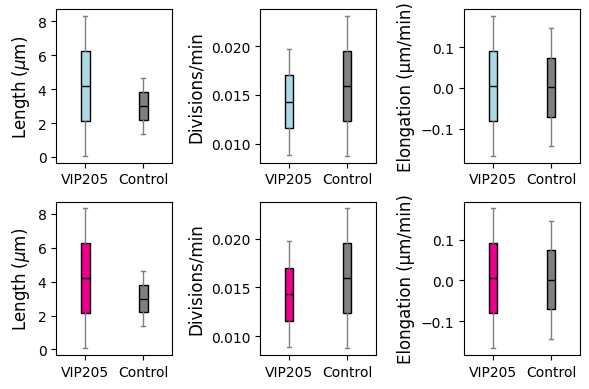

Amp Survival Comparison (Wilson Confidence Interval):
VIP: 33.33% (CI: 25.05% - 42.80%)
CFP: 29.49% (CI: 20.52% - 40.38%)

Cd Survival Comparison (Wilson Confidence Interval):
VIP: 62.50% (CI: 56.11% - 68.48%)
CFP: 60.16% (CI: 51.50% - 68.22%)


In [27]:


def plot_comparison_boxplots_all(stats_VIP_Amp, stats_CFP_Amp, stats_VIP_Cd, stats_CFP_Cd):
    """
    Compare mean cell length, division rate, and elongation rate between VIP and CFP
    for Amp and Cd conditions using boxplots. Also compute and print Wilson confidence
    intervals for survival percentages.

    Parameters:
      stats_VIP_Amp, stats_CFP_Amp: Dictionaries with statistics for VIP and CFP under Amp conditions.
      stats_VIP_Cd, stats_CFP_Cd: Dictionaries with statistics for VIP and CFP under Cd conditions.

    Returns:
      Dictionary with p-values (if computed) and confidence intervals.
    """
    # Define metrics and corresponding labels
    metrics = ["mean_cell_length", "mean_division_rate", "mean_elongation_rate"]
    metric_labels = [r"Length ($\mu$m)", "Divisions/min", r"Elongation (μm/min)"]

    # For Amp condition: extract means and errors
    vip_means_amp = [stats_VIP_Amp[metric][0] for metric in metrics]
    vip_errors_amp = [stats_VIP_Amp[metric][1] for metric in metrics]
    cfp_means_amp = [stats_CFP_Amp[metric][0] for metric in metrics]
    cfp_errors_amp = [stats_CFP_Amp[metric][1] for metric in metrics]

    vip_data_amp = [[vip_means_amp[i] - vip_errors_amp[i], vip_means_amp[i], vip_means_amp[i] + vip_errors_amp[i]] for i in range(len(metrics))]
    cfp_data_amp = [[cfp_means_amp[i] - cfp_errors_amp[i], cfp_means_amp[i], cfp_means_amp[i] + cfp_errors_amp[i]] for i in range(len(metrics))]


    # For Cd condition: extract means and errors
    vip_means_cd = [stats_VIP_Cd[metric][0] for metric in metrics]
    vip_errors_cd = [stats_VIP_Cd[metric][1] for metric in metrics]
    cfp_means_cd = [stats_CFP_Cd[metric][0] for metric in metrics]
    cfp_errors_cd = [stats_CFP_Cd[metric][1] for metric in metrics]

    vip_data_cd = [[vip_means_cd[i] - vip_errors_cd[i], vip_means_cd[i], vip_means_cd[i] + vip_errors_cd[i]] for i in range(len(metrics))]
    cfp_data_cd = [[cfp_means_cd[i] - cfp_errors_cd[i], cfp_means_cd[i], cfp_means_cd[i] + cfp_errors_cd[i]] for i in range(len(metrics))]

    # Create a figure with 2 rows (Amp on top, Cd on bottom) and 3 columns (one per metric)
    fig, axes = plt.subplots(2, 3, figsize=(6, 4))

    for i in range(len(metrics)):
        # Amp condition (row 0)
        ax_amp = axes[0, i]
        # Create the boxplot without specifying boxprops facecolor
        bp = ax_amp.boxplot(
            [vip_data_cd[i], cfp_data_cd[i]],
            labels=["VIP205", "Control"],
            patch_artist=True,
            medianprops=dict(color="black"),
            whiskerprops=dict(color="grey"),
            capprops=dict(color="grey"),
            flierprops=dict(marker="o", color="red", alpha=0.5)
        )

        # Define the desired facecolors for each box
        facecolors = ["#ADD8E6", "grey"]

        # Iterate over the boxes and set the facecolor for each
        for patch, color in zip(bp['boxes'], facecolors):
            patch.set_facecolor(color)
        ax_amp.set_ylabel(metric_labels[i], fontsize=12)
        ax_amp.tick_params(axis='x', labelsize=10)
        ax_amp.tick_params(axis='y', labelsize=10)

        # Cd condition (row 1)
        ax_cd = axes[1, i]
        # Create the boxplot without specifying boxprops facecolor
        bp = ax_cd.boxplot(
            [vip_data_cd[i], cfp_data_cd[i]],
            labels=["VIP205", "Control"],
            patch_artist=True,
            medianprops=dict(color="black"),
            whiskerprops=dict(color="grey"),
            capprops=dict(color="grey"),
            flierprops=dict(marker="o", color="red", alpha=0.5)
        )

        # Define the desired facecolors for each box
        facecolors = ["#EC008C", "grey"]

        # Iterate over the boxes and set the facecolor for each
        for patch, color in zip(bp['boxes'], facecolors):
            patch.set_facecolor(color)
        ax_cd.set_ylabel(metric_labels[i], fontsize=12)
        ax_cd.tick_params(axis='x', labelsize=10)
        ax_cd.tick_params(axis='y', labelsize=10)

    plt.tight_layout()
    plt.show()

    # Compute and print Wilson confidence intervals for survival comparison for each condition
    # Amp condition
    vip_survival_amp = stats_VIP_Amp["survival_percentage"] / 100  # Convert to proportion
    cfp_survival_amp = stats_CFP_Amp["survival_percentage"] / 100  # Convert to proportion
    n_vip_amp = stats_VIP_Amp["num_cells"]
    n_cfp_amp = stats_CFP_Amp["num_cells"]
    vip_ci_lower_amp, vip_ci_upper_amp = proportion_confint(vip_survival_amp * n_vip_amp, n_vip_amp, method='wilson')
    cfp_ci_lower_amp, cfp_ci_upper_amp = proportion_confint(cfp_survival_amp * n_cfp_amp, n_cfp_amp, method='wilson')

    print("Amp Survival Comparison (Wilson Confidence Interval):")
    print(f"VIP: {vip_survival_amp:.2%} (CI: {vip_ci_lower_amp:.2%} - {vip_ci_upper_amp:.2%})")
    print(f"CFP: {cfp_survival_amp:.2%} (CI: {cfp_ci_lower_amp:.2%} - {cfp_ci_upper_amp:.2%})")

    # Cd condition
    vip_survival_cd = stats_VIP_Cd["survival_percentage"] / 100
    cfp_survival_cd = stats_CFP_Cd["survival_percentage"] / 100
    n_vip_cd = stats_VIP_Cd["num_cells"]
    n_cfp_cd = stats_CFP_Cd["num_cells"]
    vip_ci_lower_cd, vip_ci_upper_cd = proportion_confint(vip_survival_cd * n_vip_cd, n_vip_cd, method='wilson')
    cfp_ci_lower_cd, cfp_ci_upper_cd = proportion_confint(cfp_survival_cd * n_cfp_cd, n_cfp_cd, method='wilson')

    print("\nCd Survival Comparison (Wilson Confidence Interval):")
    print(f"VIP: {vip_survival_cd:.2%} (CI: {vip_ci_lower_cd:.2%} - {vip_ci_upper_cd:.2%})")
    print(f"CFP: {cfp_survival_cd:.2%} (CI: {cfp_ci_lower_cd:.2%} - {cfp_ci_upper_cd:.2%})")

    # Return p-values and confidence intervals if needed
    return {
        "p_values": None,  # Extend here if you compute additional p-values
        "Amp": {"VIP_CI": (vip_ci_lower_amp, vip_ci_upper_amp), "CFP_CI": (cfp_ci_lower_amp, cfp_ci_upper_amp)},
        "Cd": {"VIP_CI": (vip_ci_lower_cd, vip_ci_upper_cd), "CFP_CI": (cfp_ci_lower_cd, cfp_ci_upper_cd)}
    }

# Example usage:
results = plot_comparison_boxplots_all(stats_VIP_Amp, stats_CFP_Amp, stats_VIP_Cd, stats_CFP_Cd)
